# ScBasset: Analyzing scATACseq data

```{warning}
SCBASSET's development is still in progress. The current version may not fully reproduce the original implementation's results.
```

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [13]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [14]:
import tempfile

import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [15]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [16]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Loading data and preprocessing

Throughout this tutorial, we use [sample multiome data from 10X of 10K PBMCs](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0).

In [17]:
url = "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/10k_PBMC_Multiome_nextgem_Chromium_X/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"
mdata = muon.read_10x_h5("data/multiome10k.h5mu", backup_url=url)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from data/multiome10k.h5mu


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:571: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  self._update_attr_legacy(attr, axis, join_common, **kwargs)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pu

In [18]:
mdata

MuData object with n_obs × n_vars = 10970 × 148344
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10970 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [19]:
adata = mdata.mod["atac"]

We can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [20]:
print(adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(10970, 111743)
(10970, 37054)


In [21]:
adata.var

,gene_ids,feature_types,genome,interval,n_cells
chr1:629395-630394,chr1:629395-630394,Peaks,GRCh38,chr1:629395-630394,1422
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,4536
chr1:778283-779200,chr1:778283-779200,Peaks,GRCh38,chr1:778283-779200,5981
chr1:816873-817775,chr1:816873-817775,Peaks,GRCh38,chr1:816873-817775,564
chr1:827067-827949,chr1:827067-827949,Peaks,GRCh38,chr1:827067-827949,3150
...,...,...,...,...,...
GL000219.1:44739-45583,GL000219.1:44739-45583,Peaks,GRCh38,GL000219.1:44739-45583,781
GL000219.1:45726-46446,GL000219.1:45726-46446,Peaks,GRCh38,GL000219.1:45726-46446,639
GL000219.1:99267-100169,GL000219.1:99267-100169,Peaks,GRCh38,GL000219.1:99267-100169,6830
KI270726.1:41483-42332,KI270726.1:41483-42332,Peaks,GRCh38,KI270726.1:41483-42332,605


In [22]:
split_interval = adata.var["gene_ids"].str.split(":", expand=True)
adata.var["chr"] = split_interval[0]
split_start_end = split_interval[1].str.split("-", expand=True)
adata.var["start"] = split_start_end[0].astype(int)
adata.var["end"] = split_start_end[1].astype(int)
adata.var

,gene_ids,feature_types,genome,interval,n_cells,chr,start,end
chr1:629395-630394,chr1:629395-630394,Peaks,GRCh38,chr1:629395-630394,1422,chr1,629395,630394
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,4536,chr1,633578,634591
chr1:778283-779200,chr1:778283-779200,Peaks,GRCh38,chr1:778283-779200,5981,chr1,778283,779200
chr1:816873-817775,chr1:816873-817775,Peaks,GRCh38,chr1:816873-817775,564,chr1,816873,817775
chr1:827067-827949,chr1:827067-827949,Peaks,GRCh38,chr1:827067-827949,3150,chr1,827067,827949
...,...,...,...,...,...,...,...,...
GL000219.1:44739-45583,GL000219.1:44739-45583,Peaks,GRCh38,GL000219.1:44739-45583,781,GL000219.1,44739,45583
GL000219.1:45726-46446,GL000219.1:45726-46446,Peaks,GRCh38,GL000219.1:45726-46446,639,GL000219.1,45726,46446
GL000219.1:99267-100169,GL000219.1:99267-100169,Peaks,GRCh38,GL000219.1:99267-100169,6830,GL000219.1,99267,100169
KI270726.1:41483-42332,KI270726.1:41483-42332,Peaks,GRCh38,KI270726.1:41483-42332,605,KI270726.1,41483,42332


In [23]:
# Filter out non-chromosomal regions
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [10]:
scvi.data.add_dna_sequence(
    adata,
    genome_name="GRCh38",
    genome_dir="data",
    chr_var_key="chr",
    start_var_key="start",
    end_var_key="end",
)
adata

Working...: 100%|██████████| 24/24 [00:02<00:00, 10.90it/s]


AnnData object with n_obs × n_vars = 10970 × 37042
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'chr', 'start', 'end'
    varm: 'dna_sequence', 'dna_code'

In [11]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
chr1:629395-630394,C,A,C,T,C,T,C,C,C,C,...,C,T,A,T,A,T,C,T,A,A
chr1:633578-634591,G,A,A,A,T,A,G,G,G,C,...,T,A,A,A,T,C,C,C,C,T
chr1:778283-779200,C,G,C,C,C,G,G,C,T,A,...,G,A,C,A,G,G,A,G,T,T
chr1:816873-817775,A,A,T,T,C,A,T,A,T,G,...,T,T,A,G,C,G,G,C,T,G
chr1:827067-827949,C,T,C,T,C,C,T,G,C,C,...,C,G,T,T,A,T,T,A,A,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:19077075-19078016,A,C,G,A,C,C,T,C,C,C,...,C,A,T,A,G,T,T,C,T,A
chrY:19567013-19567787,G,G,A,G,T,C,T,G,G,G,...,T,C,T,C,T,T,C,G,T,T
chrY:19744368-19745303,T,A,T,T,T,T,T,G,T,C,...,A,T,G,T,G,G,A,A,A,T
chrY:20575244-20576162,T,T,T,A,C,T,G,T,C,T,...,G,A,G,T,G,T,A,A,C,A


## Creating and training the model

We can now set up the AnnData object, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [25]:
# alternatively load the local preprocessed data
# import os
# temp_dir_obj = tempfile.TemporaryDirectory()

# adata_path = os.path.join(temp_dir_obj.name, "adata_scbasset.h5ad")
# adata = sc.read(adata_path, backup_url="https://exampledata.scverse.org/scvi-tools/adata_scbasset.h5ad")
# adata

  0%|          | 0.00/214M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 10970 × 37042
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'chr', 'start', 'end'
    varm: 'dna_code', 'dna_sequence'

In [26]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")

INFO     Using column names from columns of adata.obsm['dna_code']                                                 


We can now create a scBasset model object and train it!

```{note}
The default max epochs is set to 1000, but in practice scBasset stops early once the model converges, which especially for large datasets (which require fewer epochs to converge, since each epoch includes letting the model view more data).
```

Here we are using 16 bit precision which uses less memory without sacrificing performance.

In [28]:
bas = scvi.external.SCBASSET(bdata)
bas.train(max_epochs=150,precision=16)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many worke

Training:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


<Axes: xlabel='epoch'>

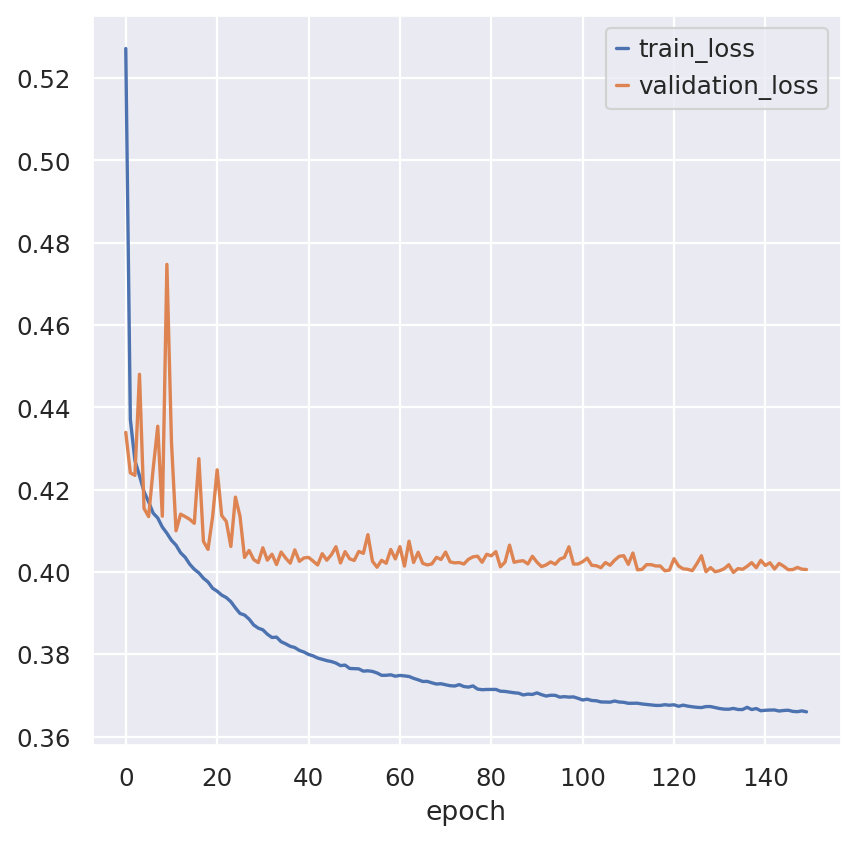

In [34]:
fig, ax = plt.subplots()
bas.history_["train_loss"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

<Axes: xlabel='epoch'>

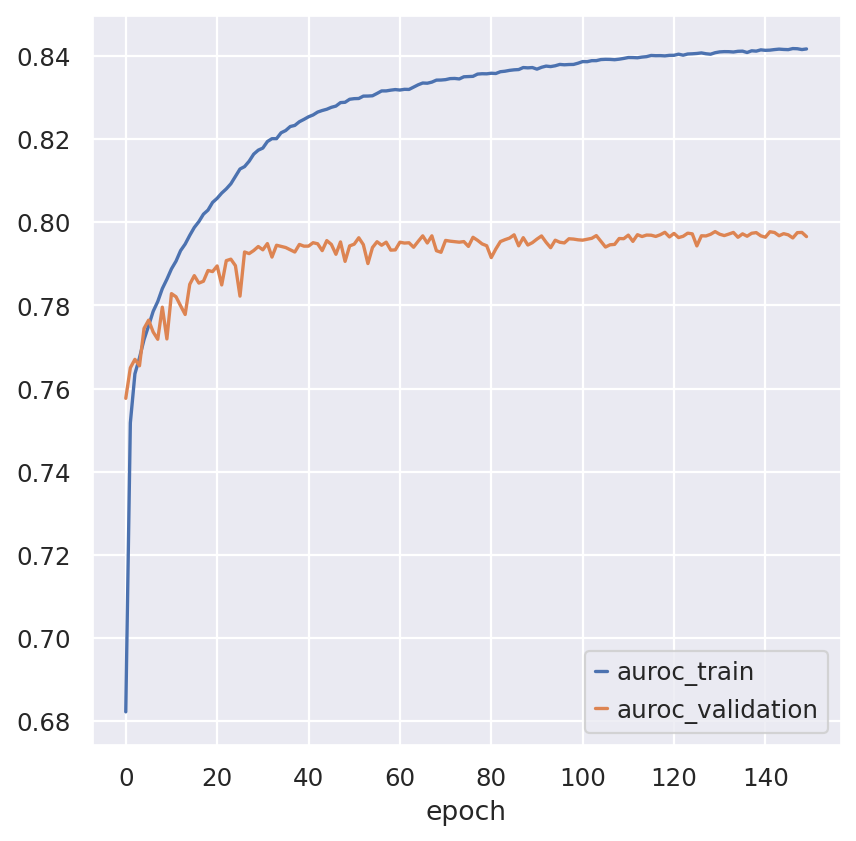

In [32]:
fig, ax = plt.subplots()
bas.history_["auroc_train"].plot(ax=ax)
bas.history_["auroc_validation"].plot(ax=ax)

## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [35]:
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

print(latent.shape)

(10970, 32)


Text(0, 0.5, 'log10(UMI count)')

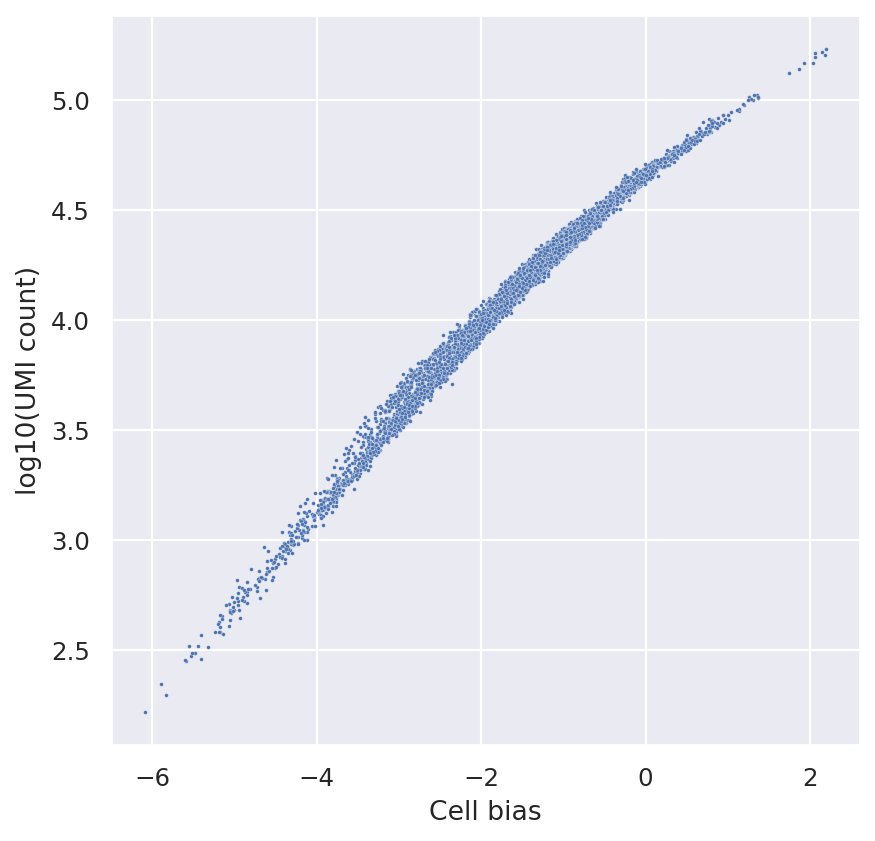

In [36]:
sns.scatterplot(
    x=bas.get_cell_bias(),
    y=np.log10(np.asarray(adata.X.sum(1))).ravel(),
    s=3,
)
plt.xlabel("Cell bias")
plt.ylabel("log10(UMI count)")

We can now use scanpy functions to cluster and visualize our latent space:

In [37]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_scbasset")
# compute the umap
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scbasset")

/tmp/ipykernel_101398/4026307039.py:5: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, key_added="leiden_scbasset")


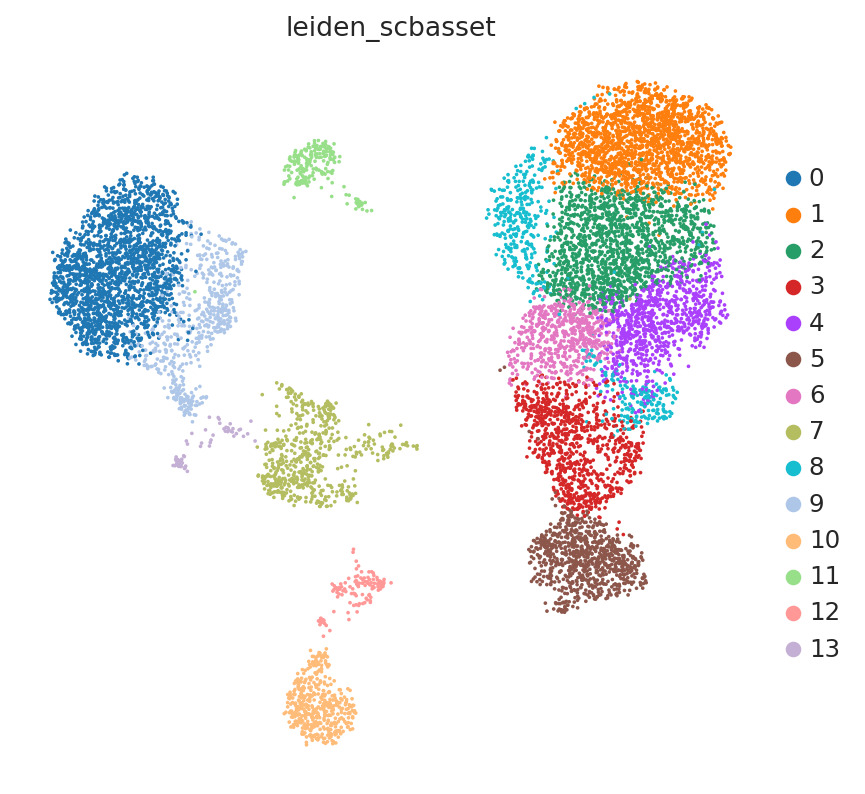

In [38]:
sc.pl.umap(adata, color="leiden_scbasset")

## Score TF activity

We will now use the motif injection procedure to infer the activity of human transcription factors using their motifs.

This process involves downloading a library of (1) random dinucleotide shuffled sequences and (2) random sequences with a known motif injected. We infer the accessibility of all the random sequences and all the motif injected sequences in every cell using the SCBASSET model. We then compute the difference in activity for the motif injected sequences and the random sequences. This difference serves as an estimate for the likelihood that a given motif is accessible in each cell, and therefore an estimate of a corresponding transcription factor's activity.

Any library with sequences of the appropriate size can be used. By default, we provide the human TF motif library used in the scBasset paper. The library is downloaded to a local folder (default: `./scbasset_motifs`). Each motif is stored in a specific FASTA file in the `{library_path}/shuffled_peaks_motifs` subdirectory. To see all available motifs, simply glob the path (e.g. `Path("./scbasset_motifs/shuffled_peaks_motifs").glob("*.fasta")`).

In [39]:
tfs = ["PAX5", "TCF7", "RXRA"]

for tf in tfs:
    adata.obs[f"bas_{tf}"] = bas.get_tf_activity(
        tf=tf,
        motif_dir="data/motifs",
    )

INFO     Downloading motif set to: data/motifs                                                                     
INFO     Downloading file at data/motifs/human_motifs.tar.gz                                                       


Downloading...:   0%|          | 0/306466.0 [00:00<?, ?it/s]

INFO     Download and extraction complete.                                                                         


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/external/scbasset/_model.py:357: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  motif_codes = pd.DataFrame([list(s) for s in motif_seqs]).applymap(_dna_to_code)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/external/scbasset/_model.py:358: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bg_codes = pd.DataFrame([list(s) for s in bg_seqs]).applymap(_dna_to_code)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/external/scbasset/_model.py:357: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  motif_codes = pd.DataFrame([list(s) for s in motif_seqs]).applymap(_dna_to_code)
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/external/scbasset/_model.py:358: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bg_codes = pd.DataFrame([list(s) for s in b

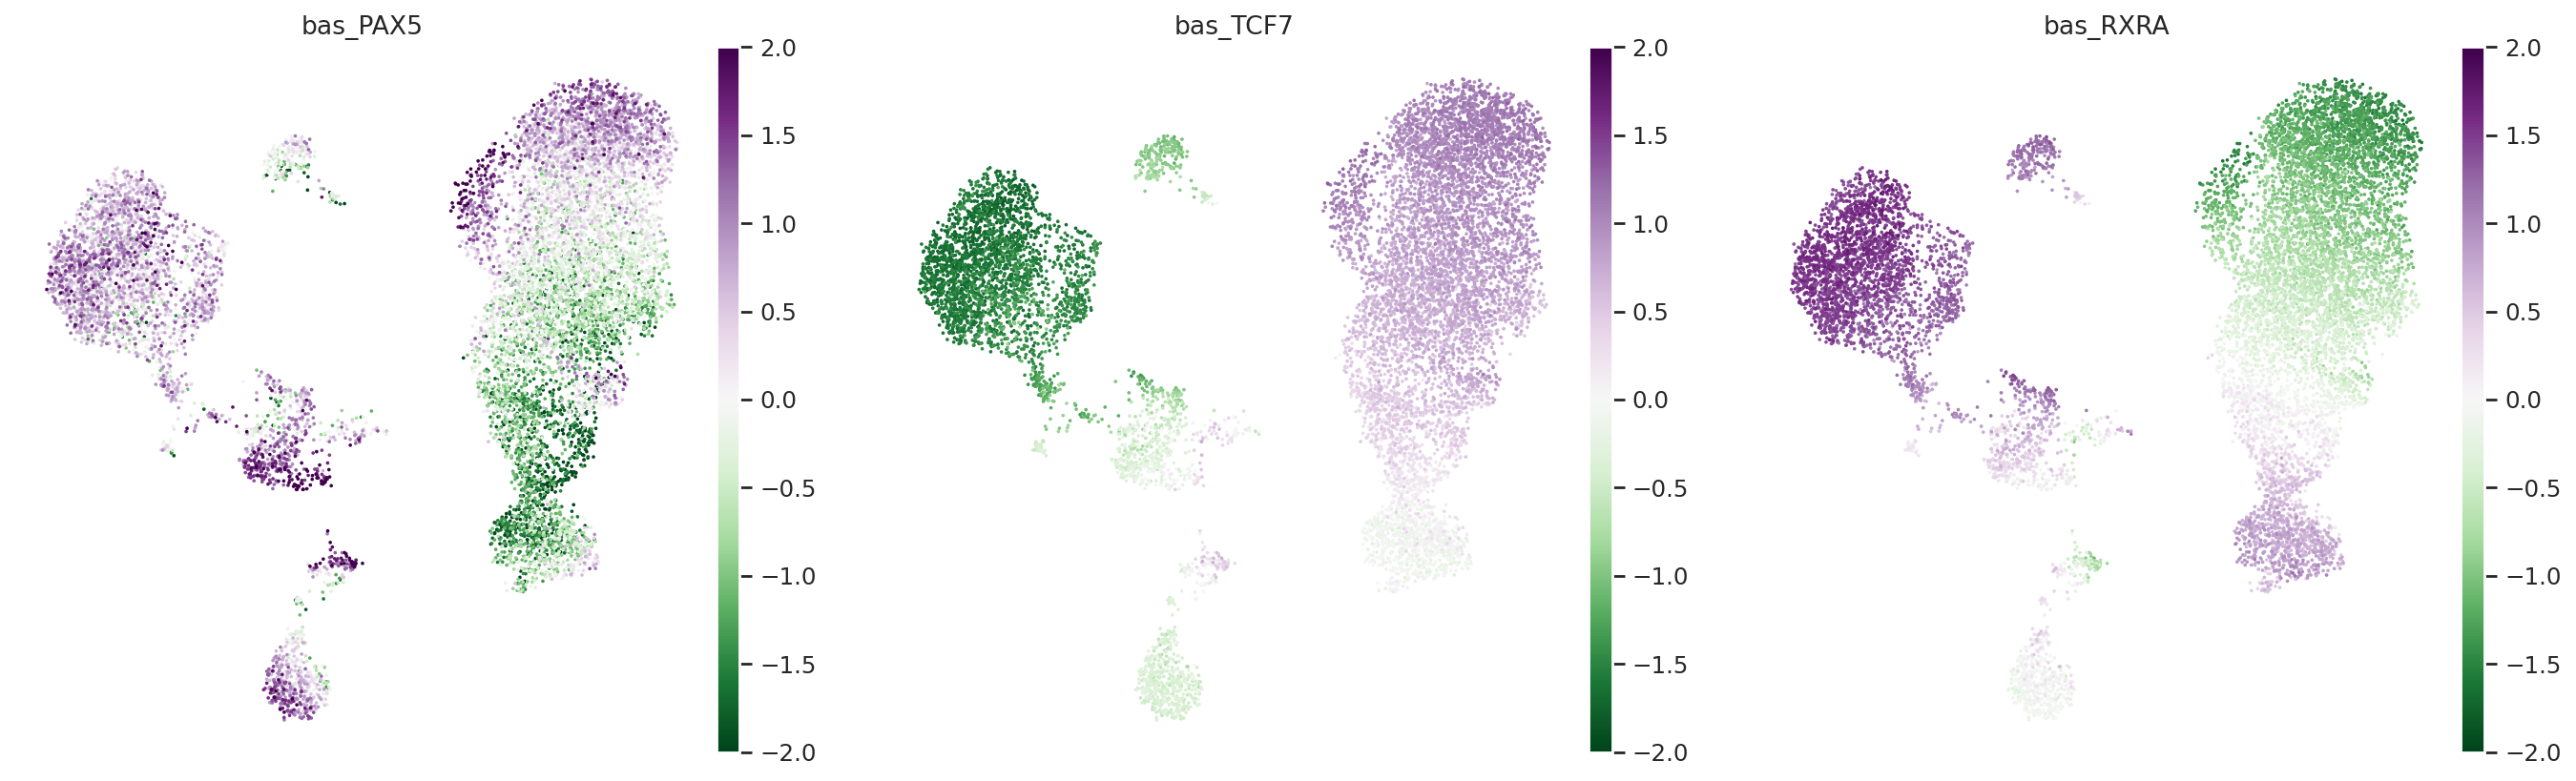

In [40]:
sc.pl.umap(
    adata,
    color=[f"bas_{tf}" for tf in tfs],
    cmap="PRGn_r",
    vmin=-2,
    vmax=2,
)